In [67]:
# Importing necessary libraries
import numpy as np
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
custom_palette = sns.color_palette()
# Set random seed for reproducibility
seed = 42
np.random.seed(seed)

# Display plots in the notebook
%matplotlib inline


In [71]:
# Define path to the data directory
data_dir = Path('./chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

categories = ['train', 'test', 'val']
subcategories = ['NORMAL','PNEUMONIA']

In [75]:
#Hyperparameters
img_size = 150
epoch= 10
batch_size = 32

In [76]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / subcategories[0]
pneumonia_cases_dir = train_dir / subcategories[1]

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,chest_xray\train\NORMAL\IM-0509-0001-0002.jpeg,0
1,chest_xray\train\PNEUMONIA\person541_bacteria_...,1
2,chest_xray\train\PNEUMONIA\person898_bacteria_...,1
3,chest_xray\train\PNEUMONIA\person595_virus_114...,1
4,chest_xray\train\PNEUMONIA\person562_virus_110...,1



Train Image Counts:
Normal: 1341 images
Pneumonia: 3875 images


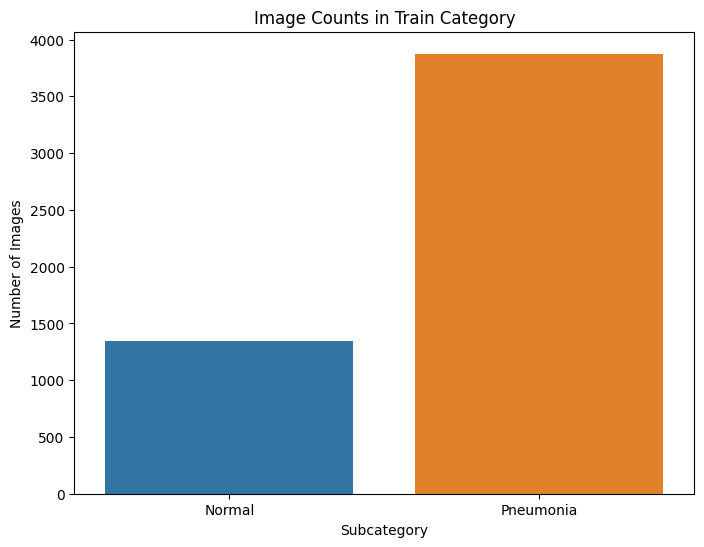


Test Image Counts:
Normal: 234 images
Pneumonia: 390 images


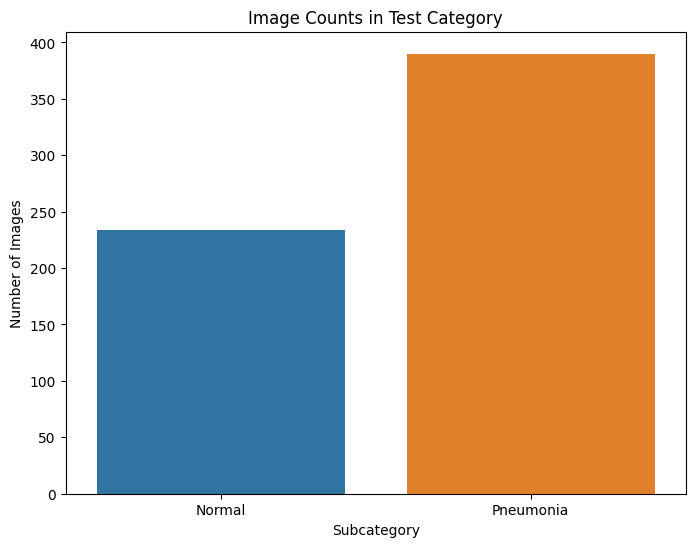


Val Image Counts:
Normal: 8 images
Pneumonia: 8 images


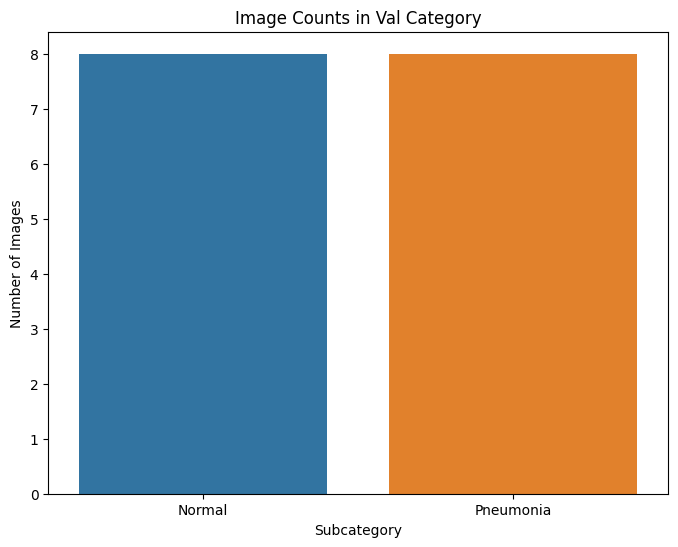

In [77]:
# Count the number of images in each folder and subcategory
for category in categories:
    category_path = data_dir / category

    print(f"\n{category.capitalize()} Image Counts:")
    
    counts = []
    labels = []

    for subcategory in subcategories:
        subcategory_path = category_path / subcategory
        image_count = len(list(subcategory_path.glob('*.jpeg')))
        print(f"{subcategory.capitalize()}: {image_count} images")
        
        counts.append(image_count)
        labels.append(subcategory.capitalize())

    # Plot the bar chart using seaborn
    plt.figure(figsize=(8, 6))
    sns.barplot(x=labels, y=counts, hue=labels)
    plt.title(f"Image Counts in {category.capitalize()} Category")
    plt.xlabel("Subcategory")
    plt.ylabel("Number of Images")
    plt.xticks(range(len(labels)), labels)
    plt.show()


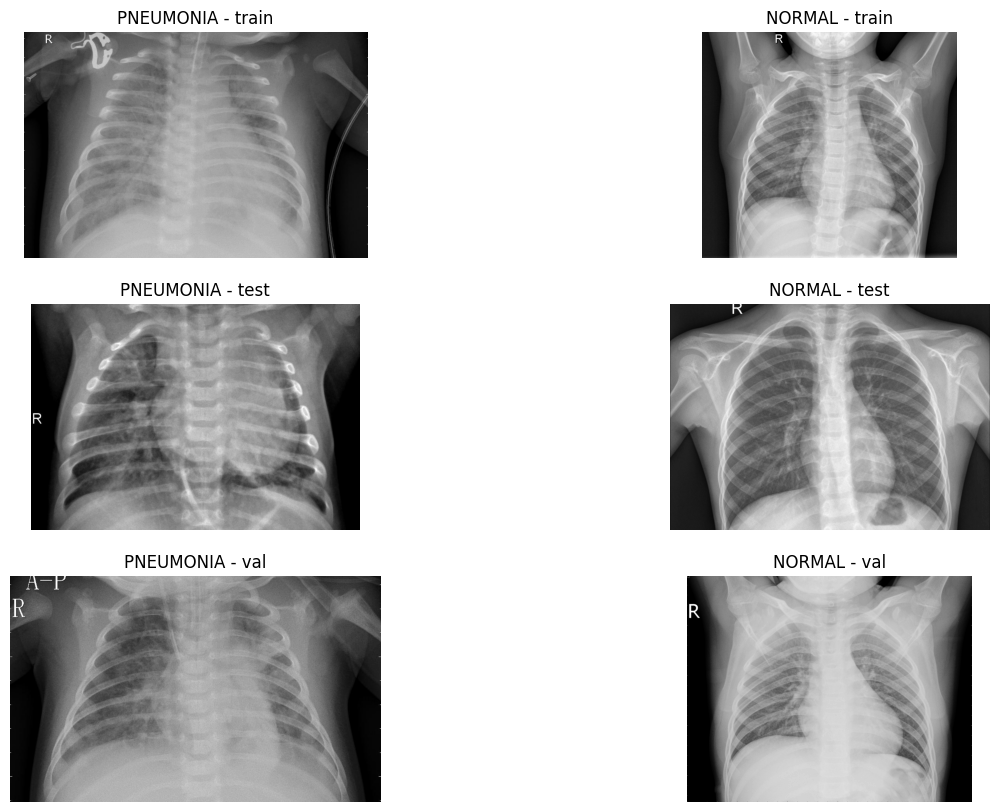

In [63]:
# Create a subplot with 3 rows and 2 columns
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

# Display one image from each category
for i, category in enumerate(categories):
    category_path = data_dir / category

    for j, subcategory in enumerate(subcategories):
        # Get the first image in the subcategory folder
        img_filename = next(category_path.joinpath(subcategory).glob('*.jpeg'))
        img_path = str(img_filename)
        
        # Load and display the image using cv2
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Access the subplot directly without ravel
        ax[i, j].imshow(img, cmap='gray')
        ax[i, j].set_title(f'{subcategory} - {category}')
        ax[i, j].axis('off')

plt.show()

In [78]:
# Get the path to the sub-directories
normal_cases_dir = val_dir / subcategories[0]
pneumonia_cases_dir = val_dir / subcategories[1]

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 150*150 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (img_size,img_size))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (img_size,img_size))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (16, 150, 150, 3)
Total number of labels: (16, 2)
